# Abhishek Singh (aulakh.abhishek@gmail.com)
# Melanoma Detection CNN Model Assignment 



* Objective: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.





* The dataset consists of about 2357 images of skin cancer types. It has 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. **Melanoma**
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion

* A Convolutional Neural Network (CNN) will be built with various techniques to correct classify the type of Skin Cancer based on input of a Image.

## Importing the Libraries

In [108]:
# Standard Python Libraries
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow Backend libraries (Keras API)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import PIL
from glob import glob

Mounting the Google Drive to load the dataset 

In [109]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/CNN/Melenoma_Detection_CNN_DS/'
print(root_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive/My Drive/CNN/Melenoma_Detection_CNN_DS/


## Data Preprocessing
Importing the training & test dataset from Google Drive mounts 

In [112]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Test')
print(data_dir_train)
print(data_dir_test)

/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train
/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Test


In [113]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Setting up the Image Size to 180x180  & batch size of 32

In [114]:
batch_size = 32
img_height = 180
img_width = 180

Importing the Training & Test Dataset from mounted Google Drive
* Splitting Training & Validation Dataset with 80:20 ratio 

In [115]:
#data_dir_train="path to directory with training data"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [116]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [117]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


- The dataset is loaded and split into train & validation set
- All 9 classes are captured in the class_names list. 

In [118]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data Visualiation

Let's try to visualize a single instance of Image from each class from the training set

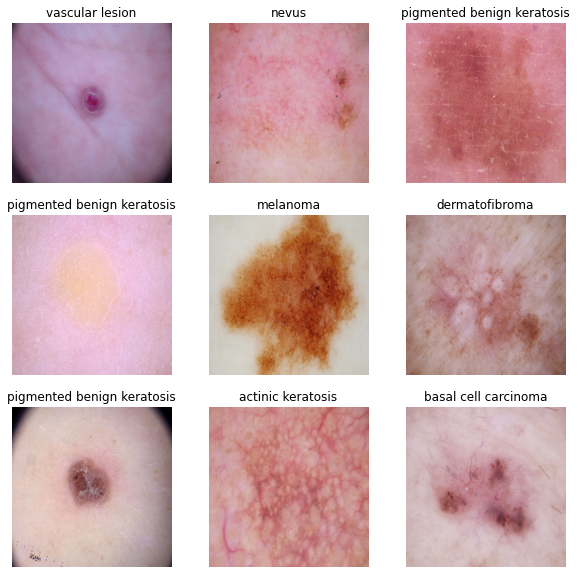

In [ ]:
plt.figure(figsize=(10, 10))
#class_names = test_data.class_names
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Image belonging each of the class is shown above in 3x3 grid

* The image_batch is a tensor of the shape (32, 180, 180, 3) which means that it is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB. 
* Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.
* Dataset.prefetch() overlaps data preprocessing and model execution while training.
* Let's set some defaults for cache & prefetch in the training & validation set







In [119]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## CNN Modelling


* After Importing & splitting the data set, We will move ahead to build a very basic **CNN model** to accurately predict the 9 class in the dataset.



* Keral Sequentaial API layers for 
  - Resizing the images to 180x180 pixel format 
  - Rescaling the images to have a pixel value between 0 and 1 for normalization

In [120]:
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

* A simple CNN model with Rescaling, 4 CNN Layers, BatchNormalization,  2 Pooling, Dropouts and 2 Dense layers
  - CNN architechture ==>  Keras-Sequential[ rescaling -> [[Conv2D(relu)] -> BatchNorm -> MaxPool2D]*2 -> Flatten -> Dense(relu) -> Dropout -> Out (Dense(Softmax))]

In [126]:
image_shape = (180, 180, 3)
num_classes = len(class_names)

model = tf.keras.Sequential([
                             resize_and_rescale,
# First Conv2D Layer [ReLu] -> MaxPooling 
                             layers.Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=image_shape),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
# Second Conv2D Layer [ReLu] -> MaxPooling 
                             layers.Conv2D(32, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Dropout(0.25),
# Third Conv2D Layer [ReLu] -> MaxPooling 
                             layers.Conv2D(32, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
# Fourth Conv2D Layer [ReLu] -> MaxPooling 
                             layers.Conv2D(32, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Dropout(0.25),
#Flattenning
                             layers.Flatten(),
#Dense Layer
                             layers.Dense(512, activation='relu'),
                             layers.Dropout(0.5),
#Output layer
                             layers.Dense(num_classes, activation='softmax')
                             ])

Compile the Model

In [127]:
#opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Training of Models with 20 epochs

In [128]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 68ms/step - loss: 3.3326 - accuracy: 0.3577 - val_loss: 5.9133 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 3s 62ms/step - loss: 1.7028 - accuracy: 0.4269 - val_loss: 10.2790 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 3s 62ms/step - loss: 1.4602 - accuracy: 0.5022 - val_loss: 12.9730 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 4s 63ms/step - loss: 1.3084 - accuracy: 0.5469 - val_loss: 10.8113 - val_accuracy: 0.1275
Epoch 5/20
56/56 [==============================] - 3s 63ms/step - loss: 1.2284 - accuracy: 0.5592 - val_loss: 9.2593 - val_accuracy: 0.2841
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 1.1848 - accuracy: 0.5709 - val_loss: 5.8332 - val_accuracy: 0.1991
Epoch 7/20
56/56 [==============================] - 4s 63ms/step - loss: 1.0828 - accuracy: 0.6138 - val_loss: 5.0266 - val_accuracy: 0.3289
Epoch 8/20

In [129]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_37 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization_55 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
batch_normalization_56 (Batc (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 45, 45, 32)      

Visualizing the Results of Accuracy & Loss with traning and validation set

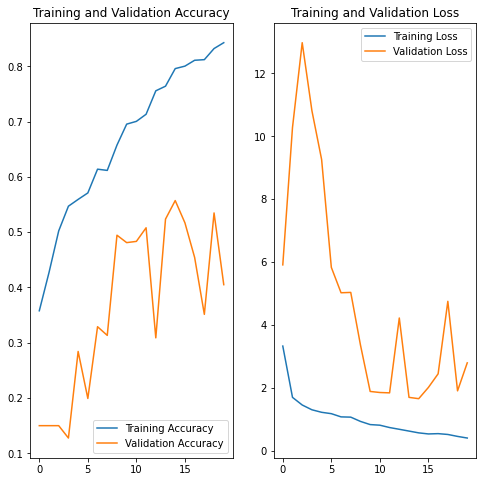

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Accuracy for Traning set gradually increased with each epochs and reached somewhere around 85% 
* Accuracy for Validation set although  remained fluctuating around 40 % to 50% in the latter part of the epoch iterations
* Loss reduced significantly for training set but can be improved further.
* Loss for Validation alothough remained high and kept fluctuating.
* This represents a classical case of **Overfitting**, where the CNN model performed well but failed to generalize on validation set



## Data Augmentaiton 

- In order to deal with Overfitting in our CNN model, We will use the Data Augmentation -  a technique to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation. 

- We will introduce Data Augmentaion in the Keras preprocessing layers inside the CNN instead of modifying the original dataset.

- Let's try to visualizing the data augmentation strategy for one instance of training image


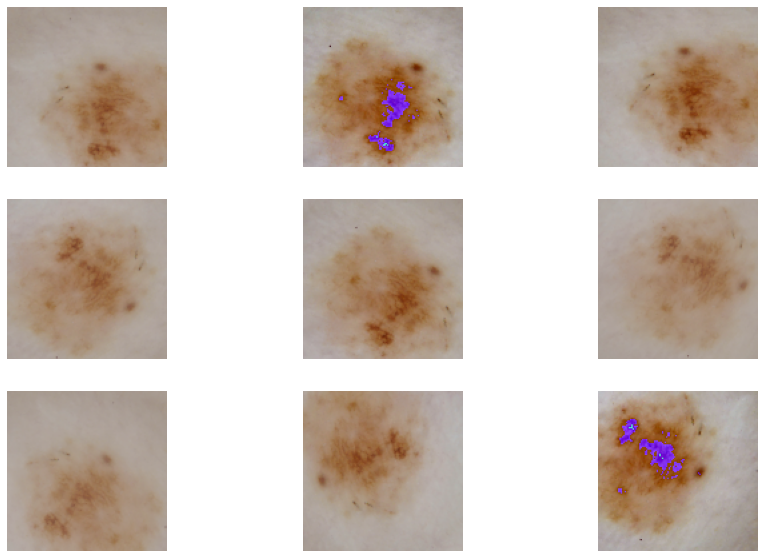

In [131]:
 data_aug = tf.keras.Sequential([
   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
   layers.experimental.preprocessing.RandomRotation(0.2),
   layers.experimental.preprocessing.RandomContrast((.5)),
   layers.experimental.preprocessing.RandomCrop(120,120)
 ]) 

batch = next(iter(train_ds))
#fig = plt.figure(figsize=(6, 6))
(image, label) = (batch[0][0], batch[1][0])
# add image to batch
image = tf.expand_dims(image,0)
plt.figure(figsize=(15,10))
for i in range(9):
  aug_image = data_aug(image)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(aug_image[0].numpy().astype("uint8"))
  plt.axis('off') 

- One class of image is randomly sampled from the training dataset and then transformations mentioned in data_aug sub-model were applied in stochastic manner
- The transformations are diplayed in a 3x3 grid 


* The objective will be to observe if the Data Augmentation will improve the Overfitting in our model and make it more generalizable and robust


### Re-Modelling using Data Augmentation to counter Overfitting 

- We will need to reload the training & validation dataset again for Rescaling and Data Augmentation

In [132]:
#data_dir_train="path to directory with training data"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


* A simple CNN model with Rescaling, Data Augmentation, 4 CNN Layers, BatchNormalization,  2 Pooling, Dropouts and 2 Dense layers
  - CNN architechture ==>  Keras-Sequential[ rescaling -> data_augmentation -> [[Conv2D(relu)] -> BatchNorm -> MaxPool2D]*2 -> Flatten -> Dense(relu) -> Dropout -> Out (Dense(Softmax))]

In [133]:
image_shape = (180, 180, 3)
num_classes = len(class_names)

IMG_SIZE = 180

# initialize our sequential data augmentation pipeline for training
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.5),
])


resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])


model = tf.keras.Sequential([
# Resizing & Rescaling layer
                             resize_and_rescale,
# Data Augmentaiton 
                              data_augmentation,
# First Conv2D Layer [ReLu] ->  BatchNorm - > MaxPooling 
                             layers.Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=image_shape),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
# Second Conv2D Layer [ReLu] ->  BatchNorm - > MaxPooling -> Dropout
                             layers.Conv2D(32, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Dropout(0.25),
# Third Conv2D Layer [ReLu] -->  BatchNorm - > MaxPooling 
                             layers.Conv2D(32, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
# Fourth Conv2D Layer [ReLu] ->  BatchNorm - > MaxPooling -> Dropout 
                             layers.Conv2D(32, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Dropout(0.25),
#Flattenning
                             layers.Flatten(),
#Dense Layer
                             layers.Dense(512, activation='relu'),
                             layers.Dropout(0.5),
#Output layer
                             layers.Dense(num_classes, activation='softmax')
                             ])


In [134]:
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

 Re-fitting the model with Data Augmentation to counter Overfitting 

In [135]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 285ms/step - loss: 3.0279 - accuracy: 0.3510 - val_loss: 3.4384 - val_accuracy: 0.0850
Epoch 2/20
56/56 [==============================] - 17s 278ms/step - loss: 1.7782 - accuracy: 0.4007 - val_loss: 5.9281 - val_accuracy: 0.1767
Epoch 3/20
56/56 [==============================] - 17s 277ms/step - loss: 1.5707 - accuracy: 0.4531 - val_loss: 6.6484 - val_accuracy: 0.1969
Epoch 4/20
56/56 [==============================] - 18s 282ms/step - loss: 1.5811 - accuracy: 0.4403 - val_loss: 7.2895 - val_accuracy: 0.2707
Epoch 5/20
56/56 [==============================] - 18s 275ms/step - loss: 1.5250 - accuracy: 0.4598 - val_loss: 7.4607 - val_accuracy: 0.2819
Epoch 6/20
56/56 [==============================] - 19s 307ms/step - loss: 1.4588 - accuracy: 0.4972 - val_loss: 7.0119 - val_accuracy: 0.2707
Epoch 7/20
56/56 [==============================] - 18s 281ms/step - loss: 1.4294 - accuracy: 0.4950 - val_loss: 5.1699 - val_accuracy: 0.2998

Visualizing the Accuracy & Loss for training & validation set accross the 20 epochs

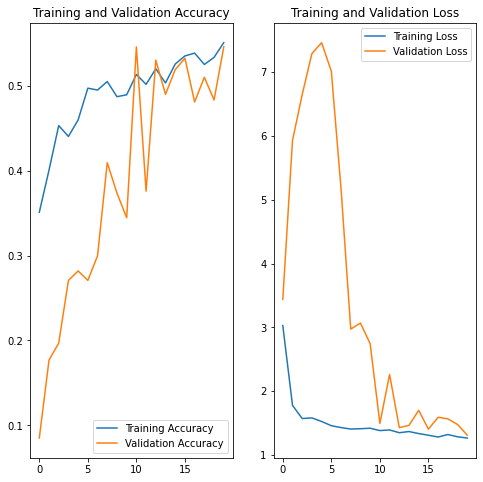

In [136]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* The model has improved in terms of Overfitting after implementing the Data Augmentation at Keras Pre-processing layers
* The Accuracy for Training set is around 55% while for the validation set also, it has imporved a bit to be around 55%
* This difference accuracy between training and validation has reduced after the implementaion of data augmentation  
* The Loss for Training & Validation reduced with epochs as a general trend
* These are good signs - Model Variance has reduced thereby improving its robustness and countering Overfitting but the Accuracy itself has dropped low to 55 % when compared what we achieved in our previous model of around 85%.
* Data Augmentation helped in increasing Variance but reduced the Bias below acceptable limits.
* This problem could be due to Class Imbalance problem where we have larger set of Images for few set of classes compared to other.
* Let's try to measure the Class Imablance problem in our dataset

### Class Imbalance in Dataset 

In [ ]:
base_dir = '/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/'
totalDir = 0
totFiles = 0
dir_file_count_dict = {}
dir = os.listdir(base_dir)
for each in dir:
  currFold = base_dir + each
  i = 0
  for i, file in enumerate(os.listdir(currFold)[0:]):
    i += 1
  print('"{}" class have {} images'.format(each, i))
  dir_file_count_dict[each] = i
  totalDir += 1
  totFiles += i
  
print('\nTotal Number of directories',totalDir)
print('Files per class:','\n',( dir_file_count_dict))

"actinic keratosis" class have 114 images
"dermatofibroma" class have 95 images
"basal cell carcinoma" class have 376 images
"pigmented benign keratosis" class have 462 images
"melanoma" class have 438 images
"seborrheic keratosis" class have 77 images
"vascular lesion" class have 139 images
"nevus" class have 357 images
"squamous cell carcinoma" class have 181 images

Total Number of directories 9
Files per class: 
 {'actinic keratosis': 114, 'dermatofibroma': 95, 'basal cell carcinoma': 376, 'pigmented benign keratosis': 462, 'melanoma': 438, 'seborrheic keratosis': 77, 'vascular lesion': 139, 'nevus': 357, 'squamous cell carcinoma': 181}


- Let's try to plot the count of images in class 

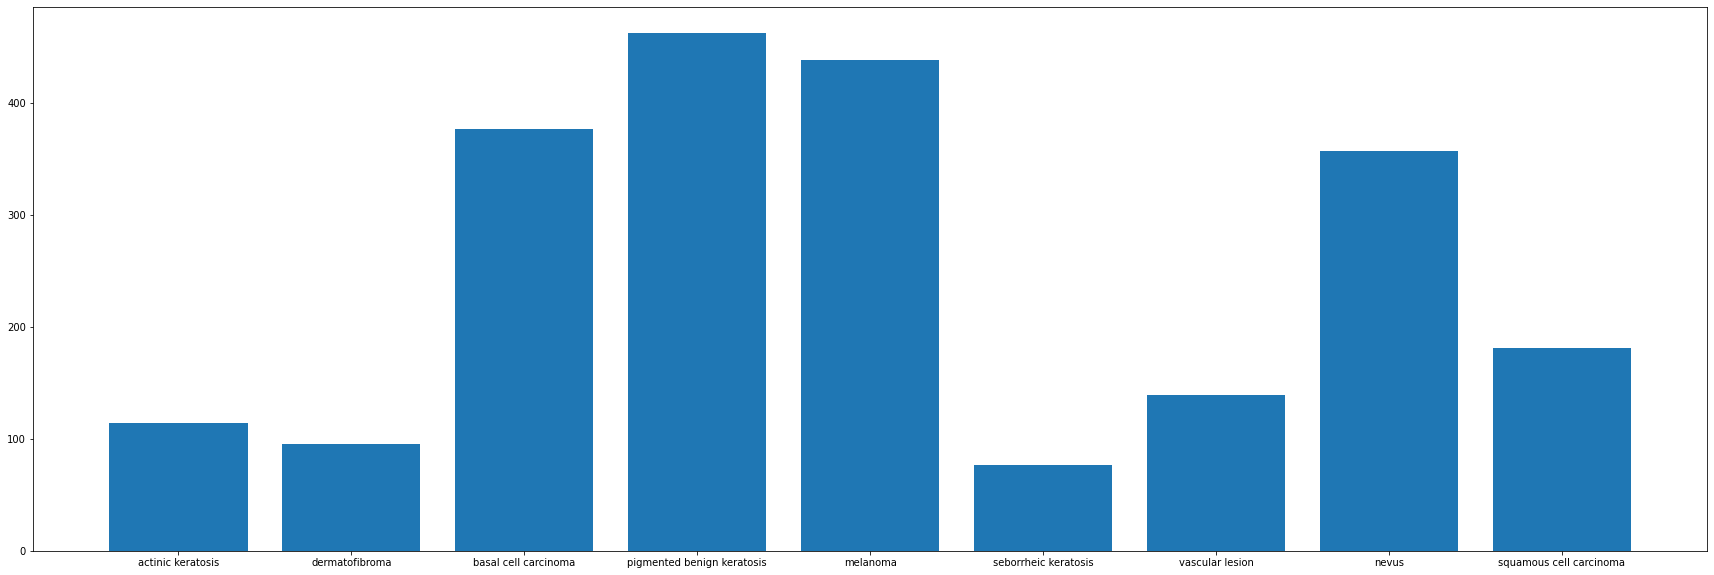

In [ ]:
fig = plt.figure(figsize=(30,10))
Classes = list(dir_file_count_dict.keys())
Count = list(dir_file_count_dict.values())
plt.bar(range(len(dir_file_count_dict)), Count, tick_label=Classes)
plt.show()

* The above barplot shows the count of Images for each class in the Training Dataset 

* 'seborrheic keratosis' has the least number of images in training dataset

* 'pigmented benign keratosis', 'basal cell carcinoma', 'nevus' and 'melanoma' classes are dominant compared to other classes

* This a confirmation of Class Imbalance which needs to be sorted out. 
* Class imbalance can have a detrimental effect on the final model quality and therefore we need to handle. 
* We will be using [Augmentor](https://augmentor.readthedocs.io/en/master/) library to counter the class imbalance problem 


## Class Imbalance Rectfication using Augmentor 

In [ ]:
# Installing Augmentor Library package. 
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

* Instantiate a Pipeline object pointing to a directory containing your initial image data set.
* Define a number of operations to perform on this data set using your Pipeline object.
* Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
import Augmentor
base_dir = '/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/'
dir = os.listdir(base_dir)
for each in dir:
  p = Augmentor.Pipeline(base_dir + each)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) 
## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F408535DC10>: 100%|██████████| 500/500 [00:21<00:00, 23.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F400BD37850>: 100%|██████████| 500/500 [00:22<00:00, 22.14 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40FCC20CD0>: 100%|██████████| 500/500 [00:22<00:00, 21.75 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F400C0439D0>: 100%|██████████| 500/500 [00:22<00:00, 22.32 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4084412E90>: 100%|██████████| 500/500 [01:44<00:00,  4.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F408533A850>: 100%|██████████| 500/500 [00:49<00:00, 10.11 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F400C034790>: 100%|██████████| 500/500 [00:23<00:00, 21.68 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F400C027450>: 100%|██████████| 500/500 [01:35<00:00,  5.24 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4085566DD0>: 100%|██████████| 500/500 [00:23<00:00, 21.65 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Before applying Augmentor pipeline, We had 2239 files in the training data set but now the total image count in training set has increased to 4500 which around 100 % increase 
- Total files in the training dataset now after Augmentor are 6739

* Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_new

{'/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030877.jpg_fdaf5320-0627-46cf-abac-193972404f5c.jpg': 'actinic keratosis',
 '/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_15e96163-380c-429f-b08a-ac88e513a221.jpg': 'actinic keratosis',
 '/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_2a1cd051-8ac5-4247-990c-8b2a035d2aea.jpg': 'actinic keratosis',
 '/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_4606d778-d174-4bfb-95b9-594280d52388.jpg': 'actinic keratosis',
 '/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_492cadd2-dbc6-463b-8580-aae06683db33.jpg': 'actinic keratosis',
 '/content/gdrive/MyDrive

In [ ]:
original_df = pd.DataFrame()
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df['Label'].value_counts()

seborrheic keratosis          500
nevus                         500
pigmented benign keratosis    500
dermatofibroma                500
squamous cell carcinoma       500
vascular lesion               500
actinic keratosis             500
basal cell carcinoma          500
melanoma                      500
Name: Label, dtype: int64

* Visualization of Count of images in training set after Augmentor

"actinic keratosis" class had 115 images and 500 images were added via Augmentor 
"dermatofibroma" class had 96 images and 500 images were added via Augmentor 
"basal cell carcinoma" class had 377 images and 500 images were added via Augmentor 
"pigmented benign keratosis" class had 463 images and 500 images were added via Augmentor 
"melanoma" class had 439 images and 500 images were added via Augmentor 
"seborrheic keratosis" class had 78 images and 500 images were added via Augmentor 
"vascular lesion" class had 140 images and 500 images were added via Augmentor 
"nevus" class had 358 images and 500 images were added via Augmentor 
"squamous cell carcinoma" class had 182 images and 500 images were added via Augmentor 


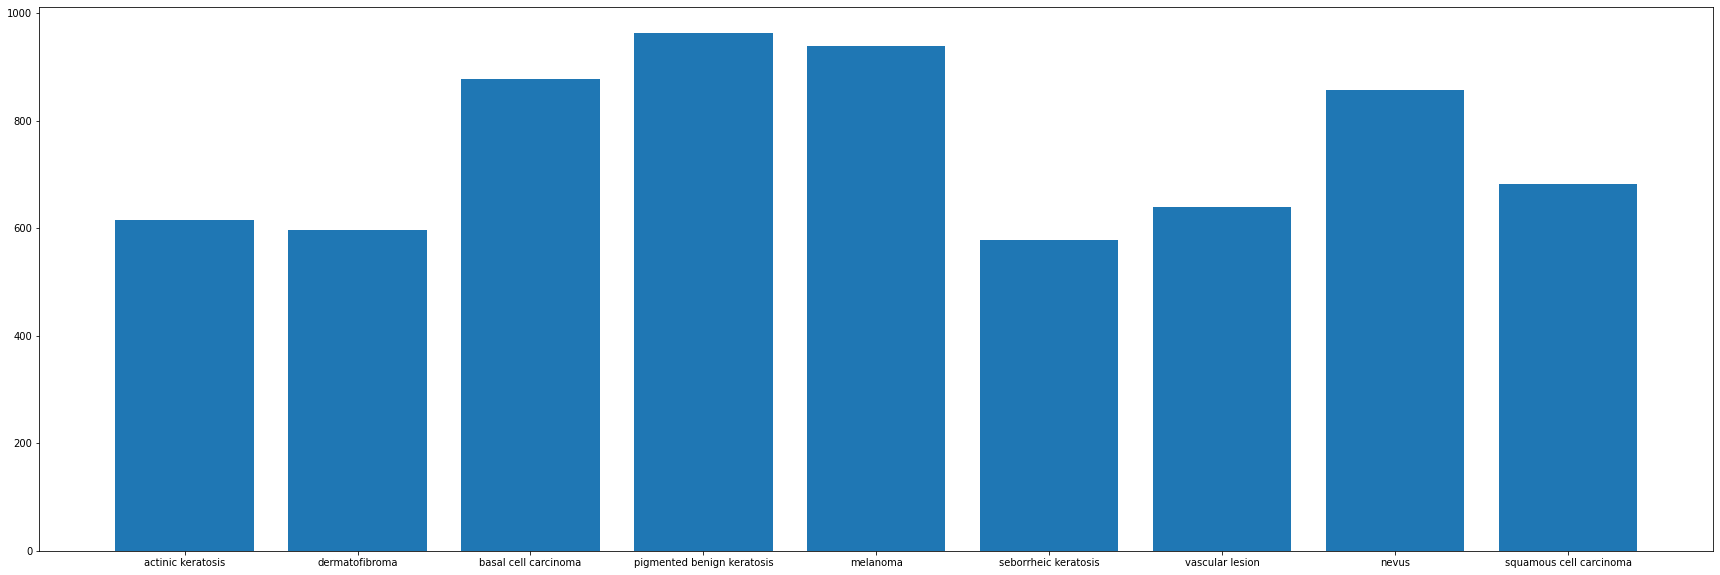

In [ ]:
base_dir = '/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/'
totalDir = 0
totFiles = 0
dir_file_count_dict = {}
dir = os.listdir(base_dir)
for each in dir:
  currFold = base_dir + each
  i = 0
  j = 0
  for i, file in enumerate(os.listdir(currFold)[0:]):
    i += 1
    outFold = currFold + '/output/'
    for j, file in enumerate(os.listdir(outFold)[0:]):
      j += 1
  print('"{}" class had {} images and {} images were added via Augmentor '.format(each, i, j))
  class_size = i + j
  dir_file_count_dict[each] = class_size
  totalDir += 1
  totFiles += i


fig = plt.figure(figsize=(30,10))
Classes = list(dir_file_count_dict.keys())
Count = list(dir_file_count_dict.values())
plt.bar(range(len(dir_file_count_dict)), Count, tick_label=Classes)
plt.show()

* As shown by the count plot for each category, The distribution of images is more balanced compared to earlier and neither of the class have sparse count.
* We will rebuild our basic CNN model on this updated training dataset after applying Augmentor pipeline and verify the Accuracy & Loss

## Re-Modelling after using Augmentor to rectify the Class Imbalance problem

- We will reload the training and validation set to update the train_ds & val_ds with the new augmented images 

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
data_dir_train="/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### CNN Model 

* We will retrain our previous CNN model on the updated dataset and see if the Model accuracy and Variance can be improved further 

 - - CNN architechture ==>  Keras-Sequential[ rescaling -> data_augmentation -> [[Conv2D(relu)] -> BatchNorm -> MaxPool2D]*2 -> Flatten -> Dense(relu) -> Dropout -> Out (Dense(Softmax))]


In [ ]:
image_shape = (180, 180, 3)
num_classes = len(class_names)

IMG_SIZE = 180

# initialize our sequential data augmentation pipeline for training
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.5),
])


resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])


model = tf.keras.Sequential([
# Resizing & Rescaling layer
                             resize_and_rescale,
# Data Augmentation 
                              data_augmentation,
# First Conv2D Layer [ReLu] ->  BatchNorm - > MaxPooling 
                             layers.Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=image_shape),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
# Second Conv2D Layer [ReLu] ->  BatchNorm - > MaxPooling -> Dropout
                             layers.Conv2D(32, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Dropout(0.25),
# Third Conv2D Layer [ReLu] -->  BatchNorm - > MaxPooling 
                             layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
# Fourth Conv2D Layer [ReLu] ->  BatchNorm - > MaxPooling -> Dropout 
                             layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Dropout(0.25),
#Flattenning
                             layers.Flatten(),
#Dense Layer
                             layers.Dense(512, activation='relu'),
                             layers.Dropout(0.5),
#Output layer
                             layers.Dense(num_classes, activation='softmax')
                             ])

In [ ]:
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 42s 234ms/step - loss: 2.5007 - accuracy: 0.3238 - val_loss: 9.1490 - val_accuracy: 0.1336
Epoch 2/20
169/169 [==============================] - 39s 225ms/step - loss: 1.5643 - accuracy: 0.4217 - val_loss: 7.4635 - val_accuracy: 0.2220
Epoch 3/20
169/169 [==============================] - 40s 229ms/step - loss: 1.3860 - accuracy: 0.4935 - val_loss: 7.2096 - val_accuracy: 0.3177
Epoch 4/20
169/169 [==============================] - 40s 227ms/step - loss: 1.3129 - accuracy: 0.5126 - val_loss: 1.5274 - val_accuracy: 0.4707
Epoch 5/20
169/169 [==============================] - 39s 223ms/step - loss: 1.1391 - accuracy: 0.5760 - val_loss: 2.8890 - val_accuracy: 0.3846
Epoch 6/20
169/169 [==============================] - 39s 223ms/step - loss: 1.0528 - accuracy: 0.5983 - val_loss: 0.8671 - val_accuracy: 0.6867
Epoch 7/20
169/169 [==============================] - 39s 225ms/step - loss: 0.9498 - accuracy: 0.6387 - val_loss: 1.0504 - val_ac

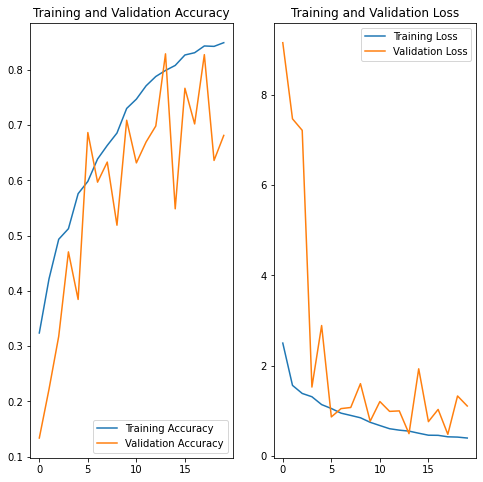

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations** 
- Accuracy 
 - For Training dataset, Accuracy improved further and reached around 84%
 - For Validation dataset, Accuracy improved from our previous model but it fluctuating between 60% and 82%

- Loss 
 - For Training dataset, Loss reduced gradually and settled at around 0.39
 - For Training dataset, Loss although reduced with each iteration but was fluctuating till the end.


- Based on above observations, We can say that the CNN model has become more generalization and robust after applying the rectification of Class Imbalance. 
- Let's apply this model on our test data set to see the results. 

In [ ]:
epochs = 20
history = model.evaluate(
    test_ds,
    #batch_size=batch_size,
    verbose=2)


4/4 - 4s - loss: 4.7408 - accuracy: 0.3559


- As can be observed, When we evaluated the model on Test dataset it gave a Accuracy of 35%
- We can definetely improve the model further by 
 - Building a Deeper Nueral Network 
 - Adding Regularization using Dropouts 
 - Running more iterations of epochs

## Deeper CNN Model 

In [ ]:
batch_size = 32
img_height = 180
img_width = 180


data_dir_train="/content/gdrive/MyDrive/CNN/Melenoma_Detection_CNN_DS/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
image_shape = (180, 180, 3)
num_classes = len(class_names)

IMG_SIZE = 180

# initialize our sequential data augmentation pipeline for training
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.5),
])


resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])


model = tf.keras.Sequential([
# Resizing & Rescaling layer
                             resize_and_rescale,
# Data Augmentation 
                              data_augmentation,
# First Conv2D Layer [ReLu] ->  BatchNorm - > MaxPooling -> Dropout
                             layers.Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=image_shape),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Dropout(0.1),
# Second Conv2D Layer [ReLu] ->  BatchNorm - > MaxPooling -> Dropout
                             layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Dropout(0.25),
# Third Conv2D Layer [ReLu] -->  BatchNorm - > MaxPooling -> Droput
                             layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Dropout(0.25),
# Fourth Conv2D Layer [ReLu] ->  BatchNorm - > MaxPooling -> Dropout 
                             layers.Conv2D(128, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Dropout(0.3),
# Fifth Conv2D Layer [ReLu] ->  BatchNorm - > MaxPooling -> Dropout 
                             layers.Conv2D(128, (3, 3), padding='same',activation='relu'),
                             layers.BatchNormalization(),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Dropout(0.3),
#Flattenning
                             layers.Flatten(),
#Dense Layer
                             layers.Dense(128, activation='relu'),
                             layers.Dropout(0.3),
                             layers.Dense(512, activation='relu'),
                             layers.Dropout(0.5),
#Output layer
                             layers.Dense(num_classes, activation='softmax')
                             ])

In [ ]:
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 41s 231ms/step - loss: 1.9970 - accuracy: 0.2791 - val_loss: 2.8273 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 39s 224ms/step - loss: 1.7440 - accuracy: 0.3498 - val_loss: 4.3558 - val_accuracy: 0.1247
Epoch 3/30
169/169 [==============================] - 39s 224ms/step - loss: 1.6248 - accuracy: 0.3824 - val_loss: 2.3931 - val_accuracy: 0.2027
Epoch 4/30
169/169 [==============================] - 38s 220ms/step - loss: 1.5106 - accuracy: 0.4221 - val_loss: 1.8516 - val_accuracy: 0.2984
Epoch 5/30
169/169 [==============================] - 38s 220ms/step - loss: 1.4498 - accuracy: 0.4349 - val_loss: 1.3046 - val_accuracy: 0.4751
Epoch 6/30
169/169 [==============================] - 39s 225ms/step - loss: 1.4028 - accuracy: 0.4560 - val_loss: 1.2320 - val_accuracy: 0.5212
Epoch 7/30
169/169 [==============================] - 39s 226ms/step - loss: 1.2918 - accuracy: 0.5052 - val_loss: 1.4969 - val_ac

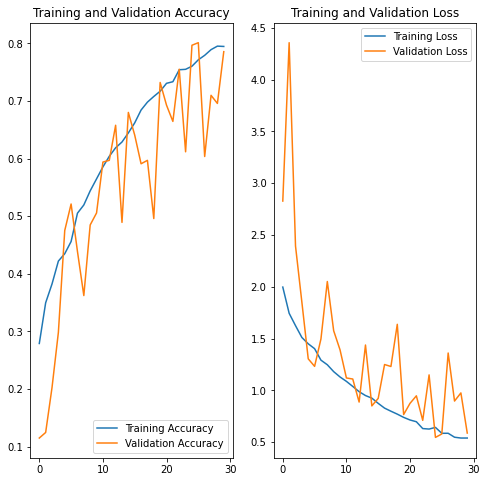

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()